# Pixel Intensity Analysis by Image Type and Gender: Implications for Occlusion-Aware Model Design

**Introduction** 
This section presents a detailed analysis of pixel intensity statistics across different subsets of the dataset. It focuses on image type (color vs. grayscale), gender, database origin, and face occlusion levels. By examining both the train and test sets, we aim to uncover systematic patterns that could inform preprocessing strategies and model architecture design.

**Conclusion**
The analysis confirms that pixel intensity is influenced by both gender and image characteristics. Women consistently show higher pixel means in color images, while men tend to have brighter grayscale images. Occlusion level strongly correlates with a drop in brightness, especially at lower levels where sample sizes are sufficient. These insights validate the need for training separate models or applying tailored normalization strategies. These strategies will based on gender, image type, and occlusion level to improve model accuracy and robustness.

# Package

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os
import pickle

In [2]:
from functions import Dataset, calculate_mean_std, plot_pixel_distribution_by_channel

# Load Data

In [3]:
df_train = pd.read_csv("df_train.csv")
df_test = pd.read_csv("df_test.csv")

# 1. EXPLORE More PIXEL DISTRIBUTION BY COLOR AND GENDER (25 min on GPU)

## Data separation by color and gender

In [4]:
# Train dataset
df = df_train.reset_index(drop=True)
df_color = df_train[df_train['color']==1].reset_index(drop=True)
df_color_w = df_color[df_color['gender_id']==0].reset_index(drop=True)
df_color_m = df_color[df_color['gender_id']==1].reset_index(drop=True)
df_gray = df_train[df_train['color']==0].reset_index(drop=True)
df_gray_w = df_gray[df_gray['gender_id']==0].reset_index(drop=True)
df_gray_m = df_gray[df_gray['gender_id']==1].reset_index(drop=True)

# Test dataset
df_test = df_test.reset_index(drop=True)
df_test_color = df_test[df_test['color']==1].reset_index(drop=True)
df_test_gray = df_test[df_test['color']==0].reset_index(drop=True)

In [5]:
print(df_color.shape)
print(df_gray.shape)

(87266, 21)
(14075, 21)


## Preparing Image Datasets for Deep Learning Experiments

In this project, multiple versions of image datasets are generated to support different training and evaluation scenarios. All images are stored in the folder 'Data/crops_100K', and each dataset is built using a custom Dataset class. This class likely loads images based on metadata provided in various DataFrames.

The datasets include both color and grayscale versions of the images, as well as different variants that may involve specific preprocessing techniques such as masking or augmentation (indicated by suffixes like _w and _m). These variations help analyze how different input types affect model performance.

In addition to training datasets, separate test datasets are also created (set_test, set_test_color, and set_test_gray) to fairly evaluate the models under different conditions.

In [6]:
# generate datasets for database 1 and 3
image_dir = 'Data/crops_100K'
set = Dataset(df, image_dir)
set_color = Dataset(df_color, image_dir)
set_color_w = Dataset(df_color_w, image_dir)
set_color_m = Dataset(df_color_m, image_dir)
set_gray = Dataset(df_gray, image_dir)
set_gray_w = Dataset(df_gray_w, image_dir)
set_gray_m = Dataset(df_gray_m, image_dir)

set_test = Dataset(df_test, image_dir)
set_test_color = Dataset(df_test_color, image_dir)
set_test_gray = Dataset(df_test_gray, image_dir)

## Creating DataLoaders for Batch Processing of Image Datasets

To efficiently train and evaluate deep learning models, the image datasets must be loaded in manageable batches. PyTorch's DataLoader provides a convenient way to batch, shuffle, and parallelize data loading during training and testing. In this step, we create separate DataLoaders for each dataset variant (color, grayscale, augmented, etc.) using a common configuration. This structure ensures that the model can be tested across different input types while maintaining consistent data handling.

In [7]:
# Create DataLoaders
params = {'batch_size': 1024,
          'shuffle': False,
          'num_workers': 0}

loader = torch.utils.data.DataLoader(set, **params)
loader_color = torch.utils.data.DataLoader(set_color, **params)
loader_color_w = torch.utils.data.DataLoader(set_color_w, **params)
loader_color_m = torch.utils.data.DataLoader(set_color_m, **params)
loader_gray = torch.utils.data.DataLoader(set_gray, **params)
loader_gray_w = torch.utils.data.DataLoader(set_gray_w, **params)
loader_gray_m = torch.utils.data.DataLoader(set_gray_m, **params)

loader_test = torch.utils.data.DataLoader(set_test, **params)
loader_test_color = torch.utils.data.DataLoader(set_test_color, **params)
loader_test_gray = torch.utils.data.DataLoader(set_test_gray, **params)

# C

This code calculates the average pixel values and standard deviations for the images.
It does this for different groups: color images, grayscale images, men, and women.
These values are useful to normalize the data before training a model.
They also help to check if the data is balanced and consistent.
The results are shown for both the training and test datasets.

In [8]:
# Pixel mean by gender and channel
print('PIXEL MEAN BY IMAGE COLOR & GENDER ')
print('--------------------------------')
print('\nTRAIN DATASET')
mean, std = calculate_mean_std(loader, num_channels=3)
print('train all:        ', mean.cpu().numpy(), 'std', std.cpu().numpy())
mean_color, std_color = calculate_mean_std(loader_color, num_channels=3)
print('train color:      ', mean_color.cpu().numpy(), 'std', std_color.cpu().numpy())
mean_color_w, std_color_w = calculate_mean_std(loader_color_w, num_channels=3)
print('train color women:', mean_color_w.cpu().numpy(), 'std', std_color_w.cpu().numpy())
mean_color_m, std_color_m = calculate_mean_std(loader_color_m, num_channels=3)
print('train color men:  ', mean_color_m.cpu().numpy(), 'std', std_color_m.cpu().numpy())
mean_gray, std_gray = calculate_mean_std(loader_gray, num_channels=3)
print('train gray:       ', mean_gray.cpu().numpy(), 'std', std_gray.cpu().numpy())
mean_gray_w, std_gray_w = calculate_mean_std(loader_gray_w, num_channels=3)
print('train gray women: ', mean_gray_w.cpu().numpy(), 'std', std_gray_w.cpu().numpy())
mean_gray_m, std_gray_m = calculate_mean_std(loader_gray_m, num_channels=3)
print('train gray men:   ', mean_gray_m.cpu().numpy(), 'std', std_gray_m.cpu().numpy())

print('\nTEST DATASET')
mean_test, std_test = calculate_mean_std(loader_test, num_channels=3)
print('test all:         ', mean_test.cpu().numpy(), 'std', std_test.cpu().numpy())
mean_test_color, std_test_color = calculate_mean_std(loader_test_color, num_channels=3)
print('test color:       ', mean_test_color.cpu().numpy(), 'std', std_test_color.cpu().numpy())
mean_test_gray, std_test_gray = calculate_mean_std(loader_test_gray, num_channels=3)
print('test gray:        ', mean_test_gray.cpu().numpy(), 'std', std_test_gray.cpu().numpy())

PIXEL MEAN BY IMAGE COLOR & GENDER 
--------------------------------

TRAIN DATASET
train all:         [0.5490321  0.44780183 0.39704853] std [0.28329352 0.25519967 0.25161627]
train color:       [0.5568131  0.43925533 0.38031605] std [0.28266937 0.24948694 0.24216689]
train color women: [0.5663896  0.44202983 0.3742314 ] std [0.28427097 0.25059047 0.2395299 ]
train color men:   [0.5500244  0.43728852 0.38462946] std [0.28133175 0.24868323 0.24392654]
train gray:        [0.5007901 0.5007901 0.5007901] std [0.28238654 0.28238654 0.28238654]
train gray women:  [0.49356565 0.49356565 0.49356565] std [0.2841281 0.2841281 0.2841281]
train gray men:    [0.50389206 0.50389206 0.50389206] std [0.28157872 0.28157872 0.28157872]

TEST DATASET
test all:          [0.5367327  0.44979802 0.40698466] std [0.28542635 0.2617557  0.2593879 ]
test color:        [0.54606795 0.43837234 0.38533452] std [0.28526628 0.25515905 0.24864338]
test gray:         [0.4976418 0.4976418 0.4976418] std [0.2827688 0.282

# Comments

The results here confirm our analysis before : 

- Color images show higher pixel means for women than men, especially in the red channel.

- Grayscale images show the opposite trend: men have higher pixel means than women.

- Channel values are equal in grayscale, as expected, and distinct in color images.

- Train and test sets are statistically consistent.

- These differences support training separate models by image type and gender for better performance.

# Comments

We can create Functions to avoid the long repetition of the code.

# 2. Explore More COLOR IMAGE BY DATABASE & GENDER


In [9]:
def filter_datasets_by_db_and_color(df, db_list, color):
    results = {}
    for db in db_list:
        df_db = df[(df['db_number'] == db) & (df['color'] == color)].reset_index(drop=True)
        results[f'db{db}'] = df_db
        if db == 3:  # Assuming gender info only for DB 3
            results[f'db{db}_men'] = df_db[df_db['gender_id'] == 1].reset_index(drop=True)
            results[f'db{db}_women'] = df_db[df_db['gender_id'] == 0].reset_index(drop=True)
    return results

In [14]:
# --- Parameters ---
dbs = [1, 2, 3]
params = {'batch_size': 1024, 'shuffle': False, 'num_workers': 0}

# --- Filter DataFrames ---
df_color_train_dict = filter_datasets_by_db_and_color(df_train, dbs, color=1)
df_gray_train_dict = filter_datasets_by_db_and_color(df_train, dbs, color=0)
df_color_test_dict = filter_datasets_by_db_and_color(df_test, [3], color=1)
df_gray_test_dict = filter_datasets_by_db_and_color(df_test, [3], color=0)

In [11]:
def create_datasets(df_dict, image_dir, dataset_class):
    return {key: dataset_class(df, image_dir) for key, df in df_dict.items()}

In [15]:
# --- Create Datasets ---
datasets_color_train = create_datasets(df_color_train_dict, image_dir, Dataset)
datasets_gray_train = create_datasets(df_gray_train_dict, image_dir, Dataset)
datasets_color_test = create_datasets(df_color_test_dict, image_dir, Dataset)
datasets_gray_test = create_datasets(df_gray_test_dict, image_dir, Dataset)

In [12]:
def create_dataloaders(dataset_dict, params):
    return {key: torch.utils.data.DataLoader(ds, **params) for key, ds in dataset_dict.items()}

In [16]:
# --- Create DataLoaders ---
loaders_color_train = create_dataloaders(datasets_color_train, params)
loaders_gray_train = create_dataloaders(datasets_gray_train, params)
loaders_color_test = create_dataloaders(datasets_color_test, params)
loaders_gray_test = create_dataloaders(datasets_gray_test, params)

In [13]:
def print_pixel_stats(loader_dict, num_channels=3, title="PIXEL STATS"):
    print(f"\n{title}")
    print("-" * len(title))
    for label, loader in loader_dict.items():
        mean, std = calculate_mean_std(loader, num_channels=num_channels)
        print(f"{label:<20}: mean {mean.cpu().numpy()} | std {std.cpu().numpy()}")

In [17]:
# --- Print Stats ---
print_pixel_stats(loaders_color_train, title="TRAIN COLOR IMAGES BY DATABASE & GENDER")
print_pixel_stats(loaders_gray_train, title="TRAIN GRAYSCALE IMAGES BY DATABASE & GENDER")
print_pixel_stats(loaders_color_test, title="TEST COLOR IMAGES DB3")
print_pixel_stats(loaders_gray_test, title="TEST GRAYSCALE IMAGES DB3")


TRAIN COLOR IMAGES BY DATABASE & GENDER
---------------------------------------
db1                 : mean [0.5637954  0.4305281  0.36255953] | std [0.2892354  0.2503864  0.23815687]
db2                 : mean [0.53494096 0.4159748  0.35325107] | std [0.3020051  0.2634911  0.25038978]
db3                 : mean [0.55355614 0.4444406  0.3904193 ] | std [0.27855986 0.24852613 0.24351525]
db3_men             : mean [0.5514771  0.44286242 0.39202595] | std [0.27885884 0.24837673 0.24444799]
db3_women           : mean [0.5585589 0.4482381 0.3865537] | std [0.27777502 0.24884416 0.24121165]

TRAIN GRAYSCALE IMAGES BY DATABASE & GENDER
-------------------------------------------
db1                 : mean [nan nan nan] | std [nan nan nan]
db2                 : mean [0.46832114 0.46832114 0.46832114] | std [0.29749572 0.29749572 0.29749572]
db3                 : mean [0.50104827 0.50104827 0.50104827] | std [0.28224826 0.28224826 0.28224826]
db3_men             : mean [0.50419724 0.50419724 0

# Concise Comment on Results : 
## Color images (Train):
- Women in DB3 have slightly higher pixel means than men, especially in the red channel.
- DB1 and DB3 have higher overall brightness than DB2.

## Grayscale images (Train):
- DB3 men have higher mean intensity than DB3 women.
- DB1 lacks grayscale data (NaNs).

## Test images (DB3):
- Color means are slightly lower than in training.
- Grayscale stats are consistent with training, but gender-specific values are missing (NaNs).

# 3. EXPLORE PIXEL DISTRIBUTION BY OCCULTATION LEVEL FOR COLOR IMAGES OF WOMEN

In [24]:
def assign_occlusion_levels(df, column='FaceOcclusion', bins=np.arange(0, 1, 0.1)):
    df = df.copy()
    df['occ_level'] = pd.cut(df[column], bins=bins.tolist(), labels=False)
    return df

In [25]:
def compute_stats_by_occlusion(df_subset, image_dir, dataset_class, params, num_levels=10, label=''):
    print(f"\n{label.upper()} - PIXEL DISTRIBUTION FOR COLOR IMAGES BY OCCLUSION LEVEL")
    results = []

    for i in range(num_levels):
        df_occ = df_subset[df_subset['occ_level'] == i].reset_index(drop=True)
        if df_occ.empty:
            mean_, std_ = [float('nan')] * 3, [float('nan')] * 3
        else:
            dataset = dataset_class(df_occ, image_dir)
            loader = torch.utils.data.DataLoader(dataset, **params)
            mean_tensor, std_tensor = calculate_mean_std(loader, num_channels=3)
            mean_ = mean_tensor.cpu().numpy().tolist()
            std_ = std_tensor.cpu().numpy().tolist()

        print(f'level {i}: mean {mean_}, std {std_}, {len(df_occ)} images')
        results.append([i, len(df_occ)] + mean_ + std_)

    df_result = pd.DataFrame(results, columns=[
        'occ_level', 'images', 'mean_R', 'mean_G', 'mean_B', 'std_R', 'std_G', 'std_B'
    ])
    df_result['mean'] = df_result[['mean_R', 'mean_G', 'mean_B']].mean(axis=1)
    return df_result

In [26]:
def save_stats(df, path):
    with open(path, 'wb') as f:
        pickle.dump(df, f)

In [27]:
def load_stats(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [28]:
def process_occlusion_analysis(df_train, image_dir, params, dataset_class, save_dir='pickle'):
    df_train = assign_occlusion_levels(df_train)

    # Women
    df_women = df_train[(df_train['color'] == 1) & (df_train['gender_id'] == 0)]
    res_w_df = compute_stats_by_occlusion(df_women, image_dir, dataset_class, params, label='WOMEN')
    save_stats(res_w_df, f'{save_dir}/pixel_distribution_train_color_w_occ_level.pkl')

    # Men
    df_men = df_train[(df_train['color'] == 1) & (df_train['gender_id'] == 1)]
    res_m_df = compute_stats_by_occlusion(df_men, image_dir, dataset_class, params, label='MEN')
    save_stats(res_m_df, f'{save_dir}/pixel_distribution_train_color_m_occ_level.pkl')

    return res_w_df, res_m_df

In [29]:
compute_by_occ_level = True

if compute_by_occ_level:
    res_w_df, res_m_df = process_occlusion_analysis(
        df_train, image_dir=image_dir, params=params,
        dataset_class=Dataset, save_dir='pickle'
    )
else:
    res_w_df = load_stats('pickle/pixel_distribution_train_color_w_occ_level.pkl')
    res_m_df = load_stats('pickle/pixel_distribution_train_color_m_occ_level.pkl')
    print(res_w_df)
    print(res_m_df)


WOMEN - PIXEL DISTRIBUTION FOR COLOR IMAGES BY OCCLUSION LEVEL
level 0: mean [0.5771182179450989, 0.45563286542892456, 0.38917601108551025], std [0.28269147872924805, 0.2512182593345642, 0.2420172542333603], 15470 images
level 1: mean [0.5673274993896484, 0.43869033455848694, 0.3685801327228546], std [0.2830810248851776, 0.24775174260139465, 0.23548050224781036], 12384 images
level 2: mean [0.5459978580474854, 0.4225829541683197, 0.3545733690261841], std [0.28528863191604614, 0.2492179274559021, 0.23634149134159088], 5520 images
level 3: mean [0.5380704402923584, 0.4123506247997284, 0.3459618389606476], std [0.2915428578853607, 0.25424280762672424, 0.23983338475227356], 2237 images
level 4: mean [0.5101596713066101, 0.39518505334854126, 0.3401245176792145], std [0.30822011828422546, 0.269056499004364, 0.2500038743019104], 251 images
level 5: mean [0.4918191432952881, 0.4039824903011322, 0.364222913980484], std [0.30787524580955505, 0.26975107192993164, 0.254698783159256], 20 images
le

# Concise Comment on Occlusion-Level Pixel Stats
- For both women and men, pixel mean decreases as occlusion level increases (levels 0–4). It reflects less visible face area and more shadow or obstruction.

- Women show higher brightness than men at each level, particularly at lower occlusions (e.g., level 0: 0.577 vs. 0.562 in red channel).

- Small sample sizes at higher occlusion levels (5–9) make trends less reliable (some contain only 1–2 images or NaNs).

- Notably, men at level 6 have an outlier: unusually high pixel mean, likely due to the single image being atypically bright.

In [3]:
with open('pickle/pixel_distribution_train_color_w_occ_level.pkl', 'rb') as f: res_w_df = pickle.load(f)
with open('pickle/pixel_distribution_train_color_w_occ_level.pkl', 'rb') as f: res_m_df = pickle.load(f)
with open('pickle/pixel_distribution_train_gray_w_occ_level.pkl', 'rb') as f: res_w_gray_df = pickle.load(f)
with open('pickle/pixel_distribution_train_gray_m_occ_level.pkl', 'rb') as f: res_m_gray_df = pickle.load(f)

# Illustration the results on graphics

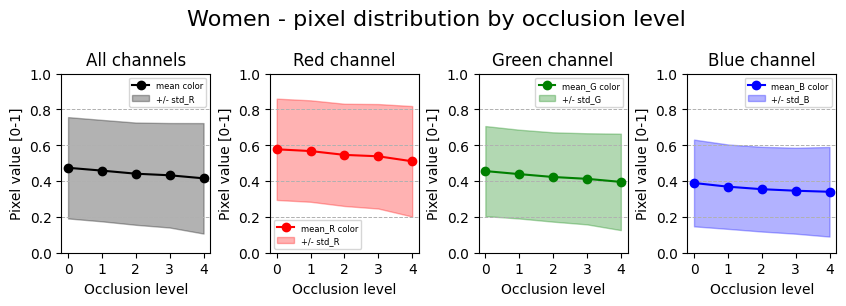

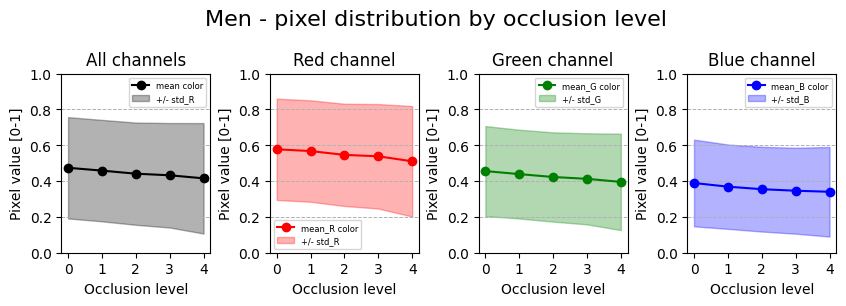

In [4]:
# Pixel distribution by occlusion level
plot_pixel_distribution_by_channel(res_w_df, "Women - pixel distribution by occlusion level")
plot_pixel_distribution_by_channel(res_m_df, "Men - pixel distribution by occlusion level")

We can observe an inverse relationship between the occlusion level and pixel values. As the occlusion level increases (towards the right), the average pixel value slightly decreases across all channels for both genders.

This suggests that occlusion introduces darker or less colorful regions in the images.

However, this graph also highlights a difference between men and women.

A new piece of information that emerges here is that the red channel shows the highest values, followed by green, then blue — this holds true for both genders. It is clearly visible here that images of women are generally brighter, and the effect of occlusion tends to lower pixel values, especially in color.

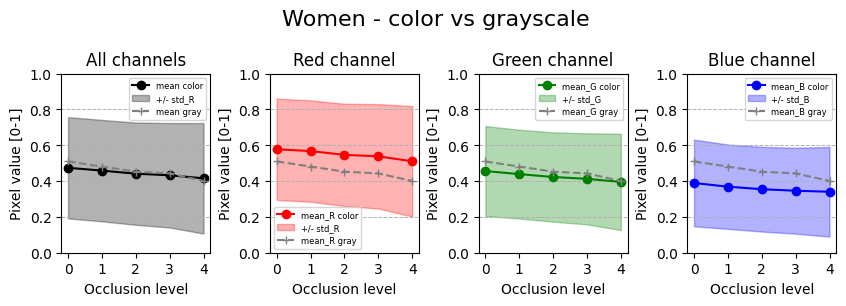

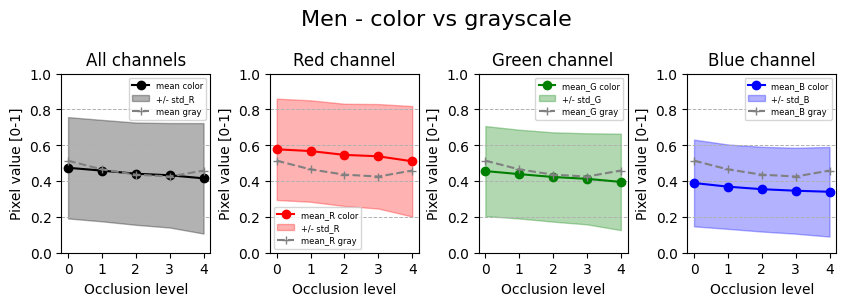

In [5]:
# Color vs grayscale
plot_pixel_distribution_by_channel(res_w_df, "Women - color vs grayscale", res_gray=res_w_gray_df)
plot_pixel_distribution_by_channel(res_m_df, "Men - color vs grayscale", res_gray=res_m_gray_df)

It is clearly visible here that images of women are generally brighter, and the effect of occlusion tends to reduce pixel values, especially in color images.